In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
filename = 'Dbig.txt'
with open(filename, 'r') as file:
    lines = file.readlines()
random.shuffle(lines)

D_8192 = lines[:8192]
with open('D_8192.txt', 'w') as file:
    file.writelines(D_8192)
    
D_2048 = lines[:2048]
with open('D_2048.txt', 'w') as file:
    file.writelines(D_2048)
    
D_512 = lines[:512]
with open('D_512.txt', 'w') as file:
    file.writelines(D_512)
    
D_128 = lines[:128]
with open('D_128.txt', 'w') as file:
    file.writelines(D_128)
    
D_32 = lines[:32]
with open('D_32.txt', 'w') as file:
    file.writelines(D_32)
    
D_test = lines[8192:]
with open('D_test.txt', 'w') as file:
    file.writelines(D_test)

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd

def entropy(data):
    if len(data) == 0:
        return 0
    d0 = len(data[data.loc[:, 'y'] == 0])
    d1 = len(data[data.loc[:, 'y'] == 1])
    p0 = d0/len(data)
    p1 = d1/len(data)
    if (p0 == 0) or (p1 == 0):
        H = 0 
    else:
        H = -p0 * math.log(p0, 2)- p1 * math.log(p1, 2)
    return H

def entropy_feature(len_left, len_right):
    p_l = len_left / (len_left + len_right)
    p_r = len_right / (len_left + len_right)
    if (p_l == 0) or (p_r == 0):
        H = 0 
    else:
        H = -p_l * math.log(p_l, 2)- p_r * math.log(p_r, 2)
    return H

def InfoGain(data, threshold, feature): 
    if len(data) == 0:
        return 0
    Data = data[[feature, 'y']]
    D_left = Data[Data[feature] >= threshold]
    D_right = Data[Data[feature] < threshold]
    p_left = len(D_left)/len(data)
    p_right = len(D_right)/len(data)
    HY = entropy(data)
    entropy_left = entropy(D_left)
    entropy_right = entropy(D_right)
    Gain = HY-(p_left * entropy_left + p_right * entropy_right)
    return Gain, len(D_left), len(D_right)

def GainRatio(data, threshold, feature):
    info_gain, len_left, len_right = InfoGain(data, threshold, feature)
    if info_gain == 0:
        return 0
    split_entropy = entropy_feature(len_left, len_right)
    return info_gain / split_entropy

class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        if self.value is not None:
            isleaf = True
        else:
            isleaf = False
        return isleaf

def decision_tree(data):
    if len(data) == 0:
        return TreeNode(value=1)
    
    if entropy(data) == 0:
        return TreeNode(value=data.iloc[0]['y'])
        
    best_gain_ratio = -math.inf
    best_feature = None
    best_threshold = None
    
    for feature in ['x1', 'x2']:
        thresholds = sorted(data[feature].unique())
        for i in range(len(thresholds) - 1):
            threshold = (thresholds[i] + thresholds[i+1]) / 2
            gain_ratio = GainRatio(data, threshold, feature)
            if gain_ratio > best_gain_ratio:
                best_gain_ratio = gain_ratio
                best_feature = feature
                best_threshold = threshold
    
    if best_gain_ratio == 0:
        if len(data[data['y'] == 1]) >= len(data[data['y'] == 0]):
            return TreeNode(value=1)
        else:
            return TreeNode(value=0)
    
    left_data = data[data[best_feature] >= best_threshold]
    right_data = data[data[best_feature] < best_threshold]
    
    left_tree = decision_tree(left_data)
    right_tree = decision_tree(right_data)
    
    return TreeNode(best_feature, best_threshold, left_tree, right_tree)


def predict(node, s):
    if node.is_leaf_node():
        return node.value
    if s[node.feature] >= node.threshold:
        return predict(node.left, s)
    return predict(node.right, s)

def plot_decision_boundary(data, tree):
    x_min, x_max = data['x1'].min(), data['x1'].max()
    y_min, y_max = data['x2'].min(), data['x2'].max()
    d = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max + d, d),
                         np.arange(y_min, y_max + d, d))

    Z = np.array([predict(tree, {'x1': x_val, 'x2': y_val}) 
                  for x_val, y_val in zip(np.ravel(xx), np.ravel(yy))])

    Z = Z.reshape(xx.shape)

    cmap_background = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_points = ListedColormap(['#FF0000', '#0000FF'])
    fig = plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.4)
    plt.scatter(data['x1'], data['x2'], c=data['y'], s=20, cmap=cmap_points, edgecolor='k', marker='o')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()
    return fig


def print_tree(data, node, space=""):
    pos_count = len(data[data['y'] == 1])
    neg_count = len(data[data['y'] == 0])
    
    if node.is_leaf_node():
        print(space + f"y = {node.value} [{'+{}'.format(pos_count)}, {'-{}'.format(neg_count)}]")
    else:
        print(space + f"[{'+{}'.format(pos_count)}, {'-{}'.format(neg_count)}] If {node.feature} >= {node.threshold} then ")
        
        left_data = data[data[node.feature] >= node.threshold]
        print_tree(left_data, node.left, space + "    ")
        
        print(space + "else")
        right_data = data[data[node.feature] < node.threshold]
        print_tree(right_data, node.right, space + "    ")
    
def predict_dataset(tree, dataset):
    predictions = []
    for _, row in dataset.iterrows():
        predictions.append(predict(tree, row))
    return predictions

def calculate_errors(actual, predicted):
    errors = sum(a != p for a, p in zip(actual, predicted))
    return errors

def count_nodes(tree):
    if not tree:
        return 0
    if tree.is_leaf_node():
        return 1
    return 1 + count_nodes(tree.left) + count_nodes(tree.right)

In [4]:
D_8192 = pd.read_csv('D_8192.txt', sep=' ', header=None)
D_8192.columns = ['x1', 'x2', 'y']

D_2048 = pd.read_csv('D_2048.txt', sep=' ', header=None)
D_2048.columns = ['x1', 'x2', 'y']

D_512 = pd.read_csv('D_512.txt', sep=' ', header=None)
D_512.columns = ['x1', 'x2', 'y']

D_128 = pd.read_csv('D_128.txt', sep=' ', header=None)
D_128.columns = ['x1', 'x2', 'y']

D_32 = pd.read_csv('D_32.txt', sep=' ', header=None)
D_32.columns = ['x1', 'x2', 'y']

D_test = pd.read_csv('D_test.txt', sep=' ', header=None)
D_test.columns = ['x1', 'x2', 'y']


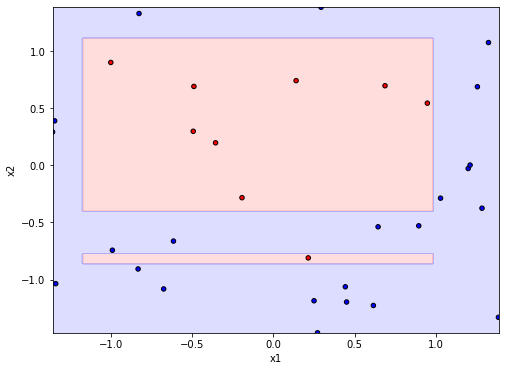

n = 32, node num = 13 ,err_n = 0.11006637168141593


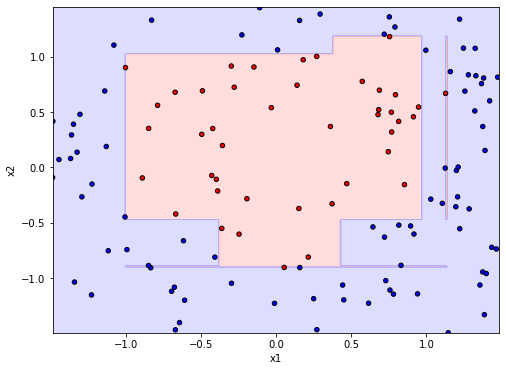

n = 128, node num = 25 ,err_n = 0.06471238938053098


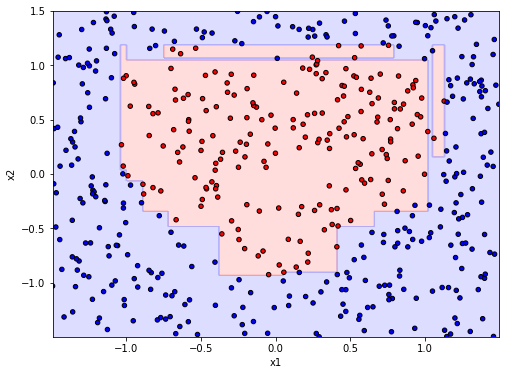

n = 512, node num = 53 ,err_n = 0.0459070796460177


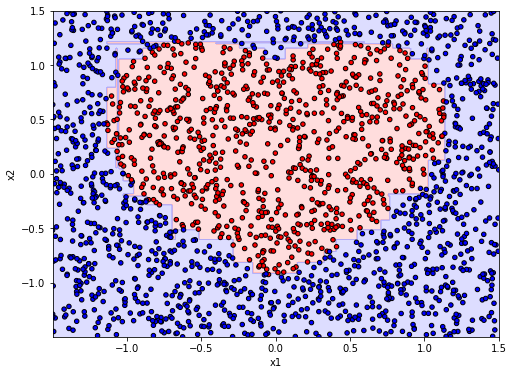

n = 2048, node num = 121 ,err_n = 0.025442477876106196


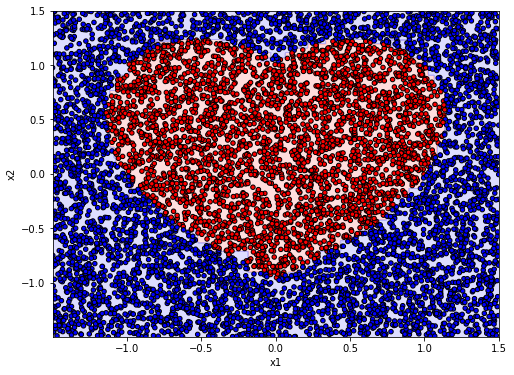

n = 8192, node num = 269 ,err_n = 0.015486725663716814


In [8]:
Data = [D_32, D_128, D_512, D_2048, D_8192]
num = [32, 128, 512, 2048, 8192]
ERRN = []
test_data = D_test
for i in range(len(Data)):
    data = Data[i]
    tree = decision_tree(data)
    fig = plot_decision_boundary(data, tree)
    predictions = predict_dataset(tree, test_data)
    err_n = calculate_errors(test_data['y'], predictions)/len(test_data)
    n = num[i]
    node_num = count_nodes(tree)
    print(f"n = {n}, node num = {node_num} ,err_n = {err_n}")
    fig.savefig('D_'+str(num[i])+'.png')
    ERRN.append(err_n)

In [9]:
ERRN

[0.11006637168141593,
 0.06471238938053098,
 0.0459070796460177,
 0.025442477876106196,
 0.015486725663716814]